<a href="https://www.kaggle.com/code/tanavbajaj/sentiment-analysis-on-hospital-comments?scriptVersionId=136177556" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Sentiment Analysis 
- Private dataset with sensitive hospital comments 

# Importing Packages

In [1]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np
import re
import pandas as pd
import spacy
import en_core_web_sm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('wordnet2022')

! cp -rf /usr/share/nltk_data/corpora/wordnet2022 /usr/share/nltk_data/corpora/wordnet # temp fix for lookup error.

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package wordnet2022 to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/wordnet2022.zip.


In [3]:
df = pd.read_csv("/kaggle/input/private-hospital-comments/comments1.csv")

# Preprocessing the Dataset 

In [4]:
df["Main Topic"] = df["Main Topic"].fillna("No Topic Given")
df = df.dropna(subset=["Content"])
nan_counts = df.isna().sum()

print(nan_counts)

Comment ID            0
Main Topic            0
Subtopic              0
Content               0
Province            420
Age                 435
Gender              425
Public Role        1573
Non-public role    4126
dtype: int64


In [5]:
# Defining regex patterns.
linebreaks        = "<br /><br />"
alphaPattern      = "[^a-z0-9<>]"
sequencePattern   = r"(.)\1\1+"
seqReplacePattern = r"\1\1"

# Defining regex for emojis
smileemoji        = r"[8:=;]['`\-]?[)d]+"
sademoji          = r"[8:=;]['`\-]?\(+"
neutralemoji      = r"[8:=;]['`\-]?[\/|l*]"
lolemoji          = r"[8:=;]['`\-]?p+"

stop_words = set(stopwords.words('english'))
Lemmatizer = WordNetLemmatizer()

In [6]:
def preprocess_reviews(review):

    review = review.lower()

    review = re.sub(linebreaks," ",review)
    # Replace 3 or more consecutive letters by 2 letter.
    review = re.sub(sequencePattern, seqReplacePattern, review)

    # Replace all emojis.
    review = re.sub(r'<3', '<heart>', review)
    review = re.sub(smileemoji, '<smile>', review)
    review = re.sub(sademoji, '<sadface>', review)
    review = re.sub(neutralemoji, '<neutralface>', review)
    review = re.sub(lolemoji, '<lolface>', review)

    # Remove non-alphanumeric and symbols
    review = re.sub(alphaPattern, ' ', review)
    
    # Tokenize the input text
    tokens = word_tokenize(review)
    
    # Remove stop words from the token sequence

    tokens = [token for token in tokens if token not in stop_words]
    
    # Lemmatize the remaining tokens
    tokens = [Lemmatizer.lemmatize(token) for token in tokens]
    
    # Join the cleaned tokens into a single string
    return ' '.join(tokens)
    

In [7]:
# combine "Main Topic", "Subtopic", and "Content" columns into a single column called "Text"
df["Text"] = df["Main Topic"] + " " + df["Subtopic"] + " " + df["Content"]

In [8]:
df["Text"] = df["Text"].apply(preprocess_reviews)

# Keyword and Sentiment Analysis using Word2Vec 
- Reference Article: https://towardsdatascience.com/unsupervised-semantic-sentiment-analysis-of-imdb-reviews-2c5f520fbf81

In [9]:
!curl https://raw.githubusercontent.com/towardsNLP/IMDB-Semantic-Sentiment-Analysis/main/Word2Vec/src/w2v_utils.py -o w2v_utils.py

curl: /opt/conda/lib/libcurl.so.4: no version information available (required by curl)
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 25779  100 25779    0     0   147k      0 --:--:-- --:--:-- --:--:--  148k


In [10]:
from w2v_utils import (Tokenizer,
                       evaluate_model,
                       bow_vectorizer,
                       train_logistic_regressor,
                       w2v_trainer,
                       calculate_overall_similarity_score,
                       overall_semantic_sentiment_analysis,
                       list_similarity,
                       calculate_topn_similarity_score,
                       topn_semantic_sentiment_analysis,
                       define_complexity_subjectivity_reviews,
                       explore_high_complexity_reviews,
                       explore_low_subjectivity_reviews,
                       text_SSA)

In [11]:

# Instancing the Tokenizer class
tokenizer = Tokenizer(clean= True,
                      lower= True, 
                      de_noise= True, 
                      remove_stop_words= True,
                      keep_negation=True)


In [12]:
df['tokenized_text'] = df['Text'].apply(tokenizer.tokenize)

df['tokenized_text_len'] = df['tokenized_text'].apply(len)
df['tokenized_text_len'].apply(np.log).describe()

count    5409.000000
mean        3.286127
std         0.509163
min         1.098612
25%         2.995732
50%         3.295837
75%         3.610918
max         4.634729
Name: tokenized_text_len, dtype: float64

In [13]:
keyed_vectors , keyed_vocab = w2v_trainer(df["tokenized_text"])

In [14]:
print(type(keyed_vectors))
print(type(keyed_vocab))

<class 'gensim.models.keyedvectors.KeyedVectors'>
<class 'dict'>


In [15]:
keyed_vectors.most_similar("research",topn=15)

[('conducted', 0.8326863646507263),
 ('stem', 0.8218376040458679),
 ('fund', 0.7980976104736328),
 ('participatory', 0.7912371158599854),
 ('mixed', 0.7855802774429321),
 ('data', 0.7738860845565796),
 ('collecting', 0.762841522693634),
 ('charity', 0.7550497651100159),
 ('parse', 0.753409743309021),
 ('thoughtful', 0.7467511892318726),
 ('pumping', 0.7440646290779114),
 ('cihr', 0.7429174780845642),
 ('shelf', 0.7390681505203247),
 ('pan', 0.7313180565834045),
 ('finding', 0.7295319437980652)]

In [16]:
keyed_vectors.most_similar("hospital",topn=15)

[('hour', 0.8509308695793152),
 ('away', 0.8507350087165833),
 ('visit', 0.849990963935852),
 ('switch', 0.8318637013435364),
 ('taking', 0.8312309980392456),
 ('back', 0.8298348784446716),
 ('clinic', 0.8231562972068787),
 ('scared', 0.8165516257286072),
 ('emerg', 0.8117086291313171),
 ('shoe', 0.8103888034820557),
 ('phone', 0.808422863483429),
 ('son', 0.8031820058822632),
 ('alarm', 0.7960094213485718),
 ('5', 0.7948176860809326),
 ('cancelling', 0.7904813885688782)]

In [17]:
keyed_vectors.most_similar("funded",topn=15)

[('fully', 0.9035855531692505),
 ('inaccessible', 0.859844982624054),
 ('albertans', 0.8461356163024902),
 ('publicly', 0.8403668403625488),
 ('rtcgms', 0.8295719027519226),
 ('essential', 0.8250473737716675),
 ('period', 0.8222774267196655),
 ('cutting', 0.8042867183685303),
 ('hybrid', 0.8037852644920349),
 ('upfront', 0.7993692755699158),
 ('subsided', 0.7957865595817566),
 ('administering', 0.7927296757698059),
 ('paid', 0.7891175150871277),
 ('wider', 0.7797703146934509),
 ('cancelling', 0.7795907855033875)]

# Clustering Approach to Sentiment Analysis

In [18]:
# To make sure that all `positive_concepts` are in the keyed word2vec vocabulary
positive_concepts = ['excellent', 'awesome', 'cool','decent','amazing', 'strong', 'good', 'great', 'funny', 'entertaining'] 
pos_concepts = [concept for concept in positive_concepts if concept in keyed_vocab]

In [19]:
# To make sure that all `negative_concepts` are in the keyed word2vec vocabulary 
negative_concepts = ['terrible','awful','horrible','boring','bad', 'disappointing', 'weak', 'poor',  'senseless','confusing'] 
neg_concepts = [concept for concept in negative_concepts if concept in keyed_vocab]


In [20]:
# Calculating Semantic Sentiment Scores by OSSA model
overall_df_scores = overall_semantic_sentiment_analysis (keyed_vectors = keyed_vectors,
                                                   positive_target_tokens = pos_concepts, 
                                                   negative_target_tokens = neg_concepts,
                                                   doc_tokens = df['tokenized_text'])

# Calculating Semantic Sentiment Scores by TopSSA model
topn_df_scores = topn_semantic_sentiment_analysis (keyed_vectors = keyed_vectors,
                                                   positive_target_tokens = pos_concepts, 
                                                   negative_target_tokens = neg_concepts,
                                                   doc_tokens = df['tokenized_text'],
                                                     topn=30)


# To store semantic sentiment store computed by OSSA model in df
df['overall_PSS'] = overall_df_scores[0] 
df['overall_NSS'] = overall_df_scores[1] 
df['overall_semantic_sentiment_score'] = overall_df_scores[2] 
df['overall_semantic_sentiment_polarity'] = overall_df_scores[3]



# To store semantic sentiment store computed by TopSSA model in df
df['topn_PSS'] = topn_df_scores[0] 
df['topn_NSS'] = topn_df_scores[1] 
df['topn_semantic_sentiment_score'] = topn_df_scores[2] 
df['topn_semantic_sentiment_polarity'] = topn_df_scores[3]

In [21]:
words = keyed_vectors.index_to_key
vectors = [keyed_vectors[word] for word in words]


In [22]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
result = pca.fit_transform(vectors)

# Create a DataFrame with PCA results and words
pca_df = pd.DataFrame(result, columns=['x', 'y'])
pca_df['word'] = words


In [23]:
import plotly.graph_objs as go

fig = go.Figure(data=go.Scattergl(
    x=pca_df['x'],
    y=pca_df['y'],
    mode='markers',
    marker=dict(
        colorscale='Viridis',
        line_width=1
    ),
    text=pca_df['word'],
    textposition="bottom center"
))

fig.show()


Text(0, 0.5, 'Predicted Positive Labels')

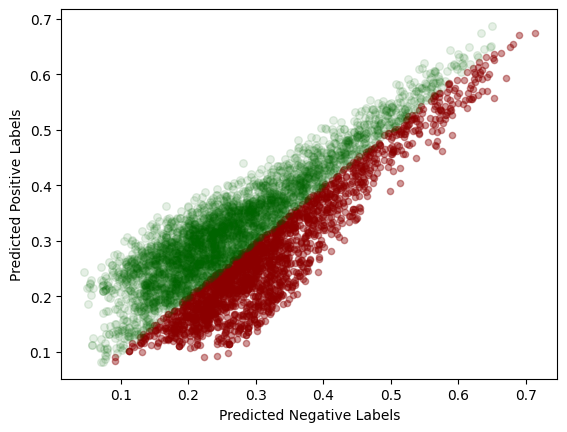

In [24]:
actual_pos_filt = df['topn_semantic_sentiment_polarity'] == 1
actual_neg_filt =  df['topn_semantic_sentiment_polarity'] == 0

# filter positive and negative review based on Most Probable predicted 'y' or 'topn_semantic_sentiment_score' column
predicted_pos_filt = df['topn_semantic_sentiment_polarity'] == 1
predicted_neg_filt = df['topn_semantic_sentiment_polarity'] == 0



# plotting Semantic Sentiment Score Position of Actual Negative Reviews 
plt.scatter(df['topn_NSS'][actual_neg_filt], 
         df['topn_PSS'][actual_neg_filt],  
         label='Actual Negetive Reviews',
           color='DarkRed',
            alpha=0.4 , # set transparency of color
            s=20 # set size of dots
           )

# plotting Semantic Sentiment Score Position of Actual Positive Reviews 
plt.scatter(df['topn_NSS'][actual_pos_filt], 
         df['topn_PSS'][actual_pos_filt],  
         label='Actual Positive Reviews',
       color='DarkGreen',
            alpha=0.1, # set transparency of color
            s=30 # set size of dots
           )
# naming the x & y axis
plt.xlabel('Predicted Negative Labels')
plt.ylabel('Predicted Positive Labels')

# Sentiment Analysis Using BERT

In [25]:
!pip install transformers

In [26]:

# importing the pipeline module
from transformers import pipeline
 
# Downloading the sentiment analysis model
SentimentClassifier = pipeline("sentiment-analysis")

# Downloading the sentiment analysis model
# SentimentClassifier = pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment")


No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [27]:
# Defining a function to call for the whole dataframe
def FunctionBERTSentiment(inpText):
  return(SentimentClassifier(inpText)[0]['label'])

In [28]:
df['BERT_Sentiment']=df['Text'].apply(FunctionBERTSentiment)
df.head(10)

,Comment ID,Main Topic,Subtopic,Content,Province,Age,Gender,Public Role,Non-public role,Text,...,tokenized_text_len,overall_PSS,overall_NSS,overall_semantic_sentiment_score,overall_semantic_sentiment_polarity,topn_PSS,topn_NSS,topn_semantic_sentiment_score,topn_semantic_sentiment_polarity,BERT_Sentiment
0,131961,Prevention,Adopt a strength-based approach that recognize...,Anyone can get diabetes should be the main mes...,BC,36 - 55,He/Him/His,y,NaN,prevention adopt strength based approach recog...,...,17,0.335171,0.480924,-0.145752,0,0.248739,0.299243,-0.050504,0,POSITIVE
1,131962,Prevention,Prevention,targeting all age groups.,BC,36 - 55,He/Him/His,y,NaN,prevention prevention targeting age group,...,5,0.213146,0.340124,-0.126979,0,0.250971,0.305859,-0.054888,0,POSITIVE
2,131963,Care Delivery,Expand integrated care and support practices w...,diabetes is a chronic illness and should be tr...,BC,36 - 55,He/Him/His,y,NaN,care delivery expand integrated care support p...,...,16,0.384161,0.234287,0.149874,1,0.238229,0.172380,0.065849,1,POSITIVE
3,131964,Care Delivery,Adopt a strength-based approach that recognize...,"Not all diabetics are the same. brittle, insul...",BC,36 - 55,He/Him/His,y,NaN,care delivery adopt strength based approach re...,...,18,0.389202,0.477113,-0.087912,0,0.264150,0.246984,0.017166,1,POSITIVE
4,131965,Care Delivery,Consider alternative health system funding mod...,"regardless of income levels, diabetes is unaff...",BC,36 - 55,He/Him/His,y,NaN,care delivery consider alternative health syst...,...,40,0.531914,0.546545,-0.014631,0,0.372116,0.336481,0.035635,1,NEGATIVE
5,131966,Care Delivery,Provide patient-centred training for medical p...,patients need comfort in speaking the truth on...,BC,36 - 55,He/Him/His,y,NaN,care delivery provide patient centred training...,...,24,0.346758,0.338310,0.008448,1,0.274377,0.244601,0.029775,1,POSITIVE
6,131967,Care Delivery,Care Delivery,"Virtual and weekends, weeknights should be a p...",BC,36 - 55,He/Him/His,y,NaN,care delivery care delivery virtual weekend we...,...,13,0.440971,0.264271,0.176701,1,0.313845,0.175102,0.138743,1,NEGATIVE
7,131968,Care Delivery,Expand integrated care and support practices w...,"More integrative, non-judgmental care is neede...",ON/QC-eng,35 & under,She/Her/Hers,NaN,y,care delivery expand integrated care support p...,...,21,0.388172,0.162846,0.225326,1,0.292420,0.164676,0.127744,1,POSITIVE
8,131969,Self-Management,Better support the implementation of national ...,Newer technologies need to be adopted quicker ...,BC,36 - 55,He/Him/His,y,NaN,self management better support implementation ...,...,21,0.488474,0.288727,0.199747,1,0.321781,0.218789,0.102992,1,NEGATIVE
9,131970,Self-Management,Build better tools to support self-management ...,Not everyone is the same.,BC,36 - 55,He/Him/His,y,NaN,self management build better tool support self...,...,14,0.315674,0.141599,0.174075,1,0.218868,0.071555,0.147314,1,NEGATIVE


In [29]:
# Defining a function to call for the whole dataframe
def FunctionBERTScore(inpText):
  return(SentimentClassifier(inpText)[0]['score'])

In [30]:
df['Score']=df['Text'].apply(FunctionBERTScore)
df.head(10)

,Comment ID,Main Topic,Subtopic,Content,Province,Age,Gender,Public Role,Non-public role,Text,...,overall_PSS,overall_NSS,overall_semantic_sentiment_score,overall_semantic_sentiment_polarity,topn_PSS,topn_NSS,topn_semantic_sentiment_score,topn_semantic_sentiment_polarity,BERT_Sentiment,Score
0,131961,Prevention,Adopt a strength-based approach that recognize...,Anyone can get diabetes should be the main mes...,BC,36 - 55,He/Him/His,y,NaN,prevention adopt strength based approach recog...,...,0.335171,0.480924,-0.145752,0,0.248739,0.299243,-0.050504,0,POSITIVE,0.992973
1,131962,Prevention,Prevention,targeting all age groups.,BC,36 - 55,He/Him/His,y,NaN,prevention prevention targeting age group,...,0.213146,0.340124,-0.126979,0,0.250971,0.305859,-0.054888,0,POSITIVE,0.860959
2,131963,Care Delivery,Expand integrated care and support practices w...,diabetes is a chronic illness and should be tr...,BC,36 - 55,He/Him/His,y,NaN,care delivery expand integrated care support p...,...,0.384161,0.234287,0.149874,1,0.238229,0.172380,0.065849,1,POSITIVE,0.998893
3,131964,Care Delivery,Adopt a strength-based approach that recognize...,"Not all diabetics are the same. brittle, insul...",BC,36 - 55,He/Him/His,y,NaN,care delivery adopt strength based approach re...,...,0.389202,0.477113,-0.087912,0,0.264150,0.246984,0.017166,1,POSITIVE,0.995901
4,131965,Care Delivery,Consider alternative health system funding mod...,"regardless of income levels, diabetes is unaff...",BC,36 - 55,He/Him/His,y,NaN,care delivery consider alternative health syst...,...,0.531914,0.546545,-0.014631,0,0.372116,0.336481,0.035635,1,NEGATIVE,0.958913
5,131966,Care Delivery,Provide patient-centred training for medical p...,patients need comfort in speaking the truth on...,BC,36 - 55,He/Him/His,y,NaN,care delivery provide patient centred training...,...,0.346758,0.338310,0.008448,1,0.274377,0.244601,0.029775,1,POSITIVE,0.980725
6,131967,Care Delivery,Care Delivery,"Virtual and weekends, weeknights should be a p...",BC,36 - 55,He/Him/His,y,NaN,care delivery care delivery virtual weekend we...,...,0.440971,0.264271,0.176701,1,0.313845,0.175102,0.138743,1,NEGATIVE,0.839959
7,131968,Care Delivery,Expand integrated care and support practices w...,"More integrative, non-judgmental care is neede...",ON/QC-eng,35 & under,She/Her/Hers,NaN,y,care delivery expand integrated care support p...,...,0.388172,0.162846,0.225326,1,0.292420,0.164676,0.127744,1,POSITIVE,0.996058
8,131969,Self-Management,Better support the implementation of national ...,Newer technologies need to be adopted quicker ...,BC,36 - 55,He/Him/His,y,NaN,self management better support implementation ...,...,0.488474,0.288727,0.199747,1,0.321781,0.218789,0.102992,1,NEGATIVE,0.830122
9,131970,Self-Management,Build better tools to support self-management ...,Not everyone is the same.,BC,36 - 55,He/Him/His,y,NaN,self management build better tool support self...,...,0.315674,0.141599,0.174075,1,0.218868,0.071555,0.147314,1,NEGATIVE,0.991056


In [31]:
df['Content_BERT_Sentiment']=df['Content'].apply(FunctionBERTSentiment)
df.head(10)

,Comment ID,Main Topic,Subtopic,Content,Province,Age,Gender,Public Role,Non-public role,Text,...,overall_NSS,overall_semantic_sentiment_score,overall_semantic_sentiment_polarity,topn_PSS,topn_NSS,topn_semantic_sentiment_score,topn_semantic_sentiment_polarity,BERT_Sentiment,Score,Content_BERT_Sentiment
0,131961,Prevention,Adopt a strength-based approach that recognize...,Anyone can get diabetes should be the main mes...,BC,36 - 55,He/Him/His,y,NaN,prevention adopt strength based approach recog...,...,0.480924,-0.145752,0,0.248739,0.299243,-0.050504,0,POSITIVE,0.992973,NEGATIVE
1,131962,Prevention,Prevention,targeting all age groups.,BC,36 - 55,He/Him/His,y,NaN,prevention prevention targeting age group,...,0.340124,-0.126979,0,0.250971,0.305859,-0.054888,0,POSITIVE,0.860959,POSITIVE
2,131963,Care Delivery,Expand integrated care and support practices w...,diabetes is a chronic illness and should be tr...,BC,36 - 55,He/Him/His,y,NaN,care delivery expand integrated care support p...,...,0.234287,0.149874,1,0.238229,0.172380,0.065849,1,POSITIVE,0.998893,NEGATIVE
3,131964,Care Delivery,Adopt a strength-based approach that recognize...,"Not all diabetics are the same. brittle, insul...",BC,36 - 55,He/Him/His,y,NaN,care delivery adopt strength based approach re...,...,0.477113,-0.087912,0,0.264150,0.246984,0.017166,1,POSITIVE,0.995901,NEGATIVE
4,131965,Care Delivery,Consider alternative health system funding mod...,"regardless of income levels, diabetes is unaff...",BC,36 - 55,He/Him/His,y,NaN,care delivery consider alternative health syst...,...,0.546545,-0.014631,0,0.372116,0.336481,0.035635,1,NEGATIVE,0.958913,NEGATIVE
5,131966,Care Delivery,Provide patient-centred training for medical p...,patients need comfort in speaking the truth on...,BC,36 - 55,He/Him/His,y,NaN,care delivery provide patient centred training...,...,0.338310,0.008448,1,0.274377,0.244601,0.029775,1,POSITIVE,0.980725,NEGATIVE
6,131967,Care Delivery,Care Delivery,"Virtual and weekends, weeknights should be a p...",BC,36 - 55,He/Him/His,y,NaN,care delivery care delivery virtual weekend we...,...,0.264271,0.176701,1,0.313845,0.175102,0.138743,1,NEGATIVE,0.839959,NEGATIVE
7,131968,Care Delivery,Expand integrated care and support practices w...,"More integrative, non-judgmental care is neede...",ON/QC-eng,35 & under,She/Her/Hers,NaN,y,care delivery expand integrated care support p...,...,0.162846,0.225326,1,0.292420,0.164676,0.127744,1,POSITIVE,0.996058,POSITIVE
8,131969,Self-Management,Better support the implementation of national ...,Newer technologies need to be adopted quicker ...,BC,36 - 55,He/Him/His,y,NaN,self management better support implementation ...,...,0.288727,0.199747,1,0.321781,0.218789,0.102992,1,NEGATIVE,0.830122,NEGATIVE
9,131970,Self-Management,Build better tools to support self-management ...,Not everyone is the same.,BC,36 - 55,He/Him/His,y,NaN,self management build better tool support self...,...,0.141599,0.174075,1,0.218868,0.071555,0.147314,1,NEGATIVE,0.991056,NEGATIVE


In [32]:
# df.to_csv('bert_sentiment.csv', index=False)

<AxesSubplot: >

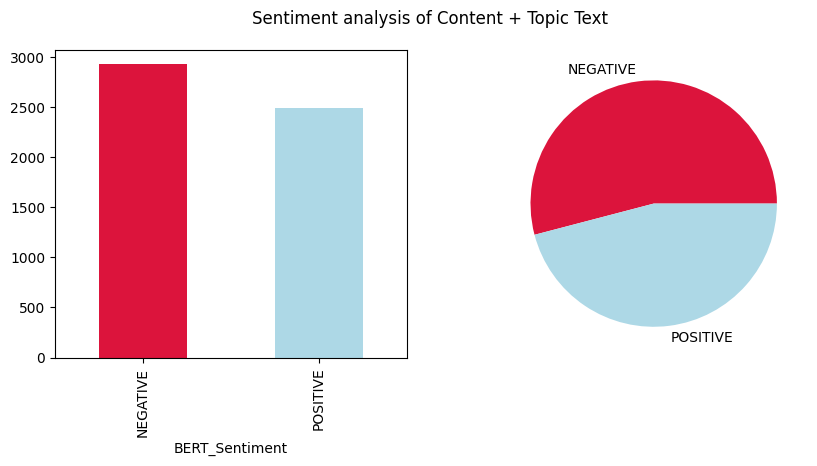

In [33]:
import matplotlib.pyplot as plt
fig, subPlot =plt.subplots(nrows=1, ncols=2, figsize=(10,4))
fig.suptitle("Sentiment analysis of Content + Topic Text")
 
# Grouping the data
GroupedData=df.groupby('BERT_Sentiment').size()
 
# Creating the charts
GroupedData.plot(kind='bar', ax=subPlot[0], color=['crimson', 'lightblue'])
GroupedData.plot(kind='pie', ax=subPlot[1], colors=['crimson', 'lightblue'])

<AxesSubplot: >

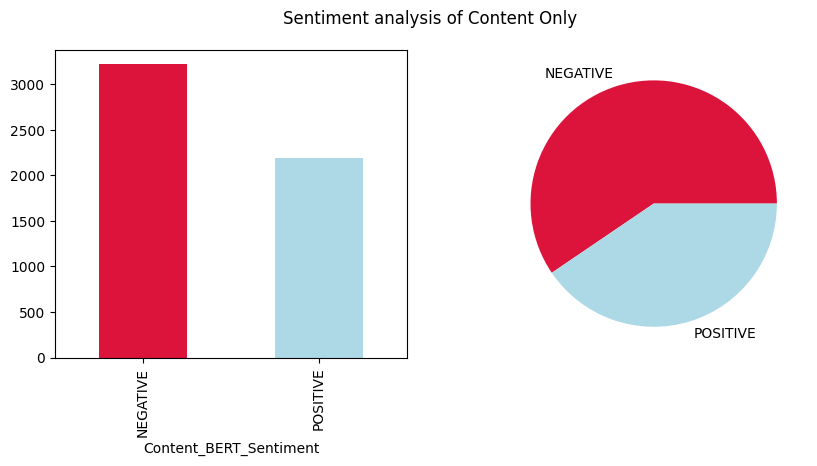

In [34]:
import matplotlib.pyplot as plt
fig, subPlot =plt.subplots(nrows=1, ncols=2, figsize=(10,4))
fig.suptitle("Sentiment analysis of Content Only")
 
# Grouping the data
GroupedData=df.groupby('Content_BERT_Sentiment').size()
 
# Creating the charts
GroupedData.plot(kind='bar', ax=subPlot[0], color=['crimson', 'lightblue'])
GroupedData.plot(kind='pie', ax=subPlot[1], colors=['crimson', 'lightblue'])